In [1]:
import torch
from unet import UNet

checkpoint = torch.load('./checkpoints/checkpoint_epoch1.pth')
model = UNet(n_channels=3, n_classes=2)
model.load_state_dict(checkpoint)

<All keys matched successfully>

In [2]:
from utils import FloodDataset
import albumentations as A
from albumentations.pytorch import ToTensorV2


image_height = 160
image_width = 240

train_transform = A.Compose(
    [
        A.Resize(height=image_height, width=image_width),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,    
        ),
        ToTensorV2(),
    ],
)

dataset = FloodDataset('./Image', './Mask', transform=train_transform)
_ = next(iter(dataset))
img, mask = _['image'], _['mask']

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.4 (you have 1.4.22). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Creating dataset...


Validating: 100%|██████████| 283/283 [00:00<00:00, 3001.41item/s]

Done


In [3]:
img_with_batch = img.unsqueeze(0)

In [5]:
model.eval()
with torch.no_grad():
    predictions = model(img_with_batch)
    if model.n_classes > 1:  # Multi-class segmentation
        pred_mask = torch.argmax(predictions, dim=1)
    else:  # Binary segmentation
        pred_mask = torch.sigmoid(predictions).squeeze(1) > 0.5

In [6]:
pred_mask.shape

torch.Size([1, 160, 240])

(-0.5, 239.5, 159.5, -0.5)

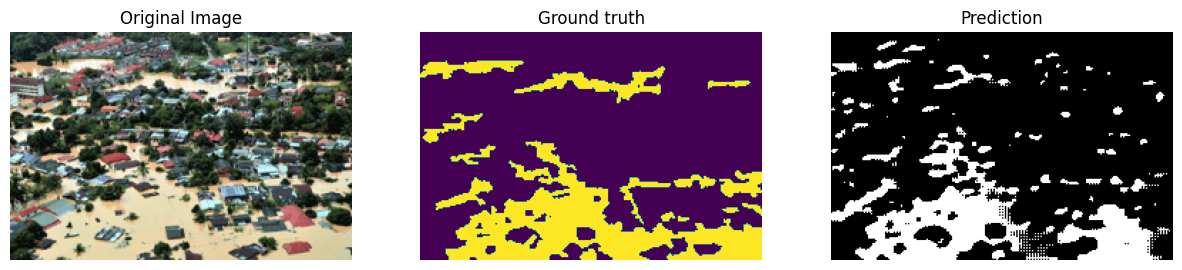

In [7]:
import matplotlib.pyplot as plt
import numpy as np

image = img.cpu()
image = np.asarray(image)
image = np.transpose(image, (1,2,0))
mask_gt = mask.cpu()
mask_gt = np.asarray(mask_gt)
pred = pred_mask.cpu()[0]

plt.figure(figsize=(15,15))

plt.subplot(1,3,1)
plt.title("Original Image")
plt.imshow(image)
plt.axis(False)

plt.subplot(1,3,2)
plt.title("Ground truth")
plt.imshow(mask_gt)
plt.axis(False)

plt.subplot(1,3,2)
plt.title("Ground truth")
plt.imshow(mask_gt)
plt.axis(False)

plt.subplot(1,3,3)
plt.title("Prediction")
plt.imshow(pred, cmap='gray')
plt.axis(False)
